In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.gridspec import GridSpec
import sys
import os
from pathlib import Path
import torch
import gpytorch
import math
import datetime
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import itertools
from mpl_toolkits.mplot3d import Axes3D
import time
import unittest
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from functools import reduce


c:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Adding modules
sys.path.append(str(Path('./').resolve().parent.parent))
from src.utils import synthetic_datasets

In [3]:
DEVICE = 'cuda' #'cuda'
FILE_PATH = '../../data/5d_rats_dataset/5D_step4.mat'


# Data setup

In [4]:
data = scipy.io.loadmat(FILE_PATH)['stim_combinations'] #scipy.io.loadmat(file_path)['Data']
resp = scipy.io.loadmat(FILE_PATH)['emg_response'] #data[0][0][0]
param = scipy.io.loadmat(FILE_PATH)['stim_combinations']# data[0][0][1]
ch2xy = param[:32,[-2,-1]].astype(int) -1
resp.shape

(8, 4, 2048, 4)

In [5]:
peak_resp = resp[:, :, :, 0]
auc_resp = resp[:, :, :, 1]
peak_norm_resp = resp[:, :, :, 2]
auc_norm_resp = resp[:, :, :, 3] 

In [6]:
def create_mean_map(resp):

    resp_mu = np.mean(resp,axis=0)
    mean_map = np.zeros((4,4,4,4,8,4))

    for e in range(resp.shape[1]):

        val_pw = np.unique(param[:,0])
        val_freq = np.unique(param[:,1])
        val_duration = np.unique(param[:,2])
        val_pos = np.unique(param[:,4])

        for i in range(len(param)):

            idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
            idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
            idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]
            #idx_ch = int(np.where(np.isclose(val_ch,param[i, 4]))[0][0]-1)
            idx_ch = int(param[i, 4]-1)

            x_ch = ch2xy[idx_ch,0]
            y_ch = ch2xy[idx_ch,1]

            mean_map[e, idx_pw, idx_freq, idx_duration, x_ch, y_ch] = resp_mu[e,i]

    return mean_map

In [7]:
peak_map = create_mean_map(peak_resp)

In [8]:
peak_map.shape
#(emg channel, pulse width, frequency, stim duration, y-coord, x-coord)

(4, 4, 4, 4, 8, 4)

In [9]:
ch2xy.shape # nb channels x nb spatial dimensions

(32, 2)

In [10]:
peak_resp = torch.from_numpy(peak_resp).float().to(DEVICE)
ch2xy = param[:, [0,1,2,5,6]]
ch2xy = torch.from_numpy(ch2xy).float().to(DEVICE)



# GPBO utils

In [11]:
def optimize(model, likelihood, training_iter, train_x, train_y, verbose= False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters lr= 0.01
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    l = 0.0

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)

      
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        l += loss
        loss.backward()

        if verbose== True:

            print('Iter %d/%d - Loss: %.3f   lengthscale_1: %.3f   lengthscale_2: %.3f   lengthscale_3: %.3f   lengthscale_4: %.3f    lengthscale_4: %.3f    kernelVar: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][2].item(),
            model.covar_module.base_kernel.lengthscale[0][3].item(),
            model.covar_module.base_kernel.lengthscale[0][4].item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()))

        optimizer.step()

    return model, likelihood, l / training_iter

In [12]:
def sample_categorical(prob_partition, size):
    #e.g. sample_cateogircal([0.1, 0.1, 0.4, 0.2, 0.2], 4) = array([2, 2, 2, 3])
    return np.random.choice(len(prob_partition), size=size, p=prob_partition)

# Main function
def sample_struct_priors(xx, yy, fixhyp):
    dx = xx.shape[1]
    n_partition = dx

    hyp = {}
    #model = SingleTaskGP(xx, yy, outcome_transform=Standardize(m=1))
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GP(xx, yy, likelihood, gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims= n_partition)))

    if all(k in fixhyp for k in ["l", "sigma", "sigma0"]):
        hyp["l"] = fixhyp["l"]
        hyp["sigma"] = fixhyp["sigma"]
        hyp["sigma0"] = fixhyp["sigma0"]
        decomp = learn_partition(xx, yy, hyp, fixhyp, n_partition, model, likelihood)
    else:
        prob_partition = np.ones(n_partition) / n_partition
        decomp = fixhyp.get("z", sample_categorical(prob_partition, dx))
        '''
        num_iter = 2
        for _ in range(num_iter):
            assert max(decomp) <= n_partition

            def compute_mll(params):
                hyp = {
                    "l": np.exp(params[:n_partition]),
                    "sigma": np.exp(params[n_partition:2 * n_partition]),
                    "sigma0": np.exp(params[2 * n_partition:])
                }
                return compute_nlz(xx, yy, hyp, decomp)

            bounds = np.vstack([
                np.tile([0, 10], (n_partition, 1)),
                np.tile([-5, 2], (n_partition, 1)),
                np.tile([-10, 1], (n_partition, 1))
            ])

            res = minimize(
                compute_mll, x0=np.zeros(bounds.shape[0]), bounds=bounds,
                method='L-BFGS-B'
            )

            best_params = res.x
            #print(f"Finished optimize hyp nll={res.fun}")

            l = np.exp(best_params[:n_partition][decomp])
            sigma = np.exp(best_params[n_partition:2*n_partition])
            sigma0 = np.exp(best_params[2*n_partition:])

            hyp["l"] = l
            hyp["sigma"] = sigma
            hyp["sigma0"] = sigma0

            decomp = learn_partition(xx, yy, hyp, fixhyp, n_partition)
            fixhyp["z"] = decomp
        '''

        # GPytorch Model Training
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iter = 50
        model.train()
        likelihood.train()

        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(model.train_inputs[0])
            loss = -mll(output, model.train_targets).mean()
            loss.backward()
            optimizer.step()

        # Extract optimized hyperparameters
        hyp["l"] = model.covar_module.base_kernel.lengthscale.detach().numpy().squeeze()
        hyp["sigma"] = model.covar_module.outputscale.detach().numpy()
        hyp["sigma0"] = model.likelihood.noise.detach().numpy()

        decomp = learn_partition(xx, yy, hyp, fixhyp, n_partition, model, likelihood)
        hyp["z"] = decomp
        

    return decomp, hyp

# Helper function to learn the partition
def learn_partition(xx, yy, hyp, fixhyp, n_partition, model, likf):
    if "decomp" in fixhyp:
        return fixhyp["decomp"]

    N_gibbs = 100
    gibbs_iter = N_gibbs // 2
    dim_limit = 3
    maxNdata = 750

    Nidx = min(maxNdata, xx.shape[0])
    xx = xx[:Nidx]
    yy = yy[:Nidx]

    hyp_dirichlet = np.ones(n_partition)
    prob_partition = hyp_dirichlet / hyp_dirichlet.sum()

    z = fixhyp.get("z", sample_categorical(prob_partition, xx.shape[1]))

    z_best = z.copy()
    minnlz = float('inf')

    for i in range(N_gibbs):
        for d in range(xx.shape[1]):
            log_prob = np.full(n_partition, -np.inf)
            nlz = np.full(n_partition, float('inf'))

            for a in range(n_partition):
                z[d] = a

                if i >= gibbs_iter and np.sum(z == a) >= dim_limit:
                    continue

                mll = ExactMarginalLogLikelihood(likf, model)
                model.train()
                nlz[a] = -mll(model(model.train_inputs[0]), model.train_targets).item()
                log_prob[a] = np.log(np.sum(z == a) + hyp_dirichlet[a]) - nlz[a]

            z[d] = np.argmax(log_prob - np.log(-np.log(np.random.rand(n_partition))))

            if minnlz > nlz[z[d]]:
                z_best = z.copy()
                minnlz = nlz[z[d]]

    return z_best


# Simple GPBO

In [13]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(GP, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel
        self.name = 'VanillaGPBO'

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [25]:
def neurostim_BO(GP_model, this_opt, options=None):

    # Setting default options
    if options is None:
        options = {}
    options.setdefault('n_subjects', 4)
    options.setdefault('n_dims', 5)
    options.setdefault('dim_sizes', np.array([8,4,4,4,4]))
    options.setdefault('which_opt','kappa') 
    options.setdefault('rho_low', 0.1)
    options.setdefault('rho_high', 6.0) 
    options.setdefault('nrnd', 5)
    options.setdefault('noise_min', 0.25)
    options.setdefault('noise_max', 10)
    options.setdefault('MaxQueries', 200) 
    options.setdefault('kappa', 20) 
    options.setdefault('nRep', 30) 

    #Params initialization
    n_subjects = options['n_subjects']
    n_dims = options['n_dims']
    DimSearchSpace = np.prod(options['dim_sizes'])
    rho_low = options['rho_low']
    rho_high = options['rho_high']
    nrnd = options['nrnd']
    noise_min = options['noise_min']
    noise_max = options['noise_max']
    MaxQueries = options['MaxQueries']
    kappa = options['kappa']
    nRep = options['nRep']
    total_size = np.prod(options['dim_sizes'])

    #Metrics initialization
    PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
    PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
    Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
    LOSS = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
    Train_time = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)



    for s_idx in range(n_subjects):

        # "Ground truth" map
        MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
        mMPm= torch.max(MPm)

        kappa= this_opt[0]

        # Create kernel, likelihood and priors
        # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
        #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
        #The outputscale parameter is parameterized on a log scale to constrain it to be positive
        priorbox= gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low),b= math.log(rho_high), sigma=0.01) 
        priorbox2= gpytorch.priors.SmoothedBoxPrior(a=math.log(0.01**2),b= math.log(100.0**2), sigma=0.01) # std
        matk= gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims= n_dims, lengthscale_prior= priorbox)

        matk_scaled = gpytorch.kernels.ScaleKernel(matk, outputscale_prior= priorbox2)
        matk_scaled.base_kernel.lengthscale= [1.0]*n_dims
        matk_scaled.outputscale= [1.0]
        prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
        likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
        likf.noise= [1.0] 

         #Initialize subject metrics
        perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
        perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
        loss = torch.zeros((nRep, MaxQueries), device=DEVICE)
        perf_rsq= torch.zeros((nRep), device=DEVICE)
        train_time = torch.zeros((nRep, MaxQueries), device=DEVICE)
        P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
        P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

        for rep_i in range(nRep): # for each repetition

            if rep_i % 10 == 0:
                print('rep: ' + str(rep_i))
            
            MaxSeenResp=0 
            q=0 # query number                                
            order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
            P_max=[]
            hyp=[1.0]*(n_dims+2)

            while q < MaxQueries:

                # Burnout queries
                if q < nrnd:
                    P_test[rep_i][q][0]=int(order_this[q])
                
                #Find next point (max of acquisition function)
                else:
                
                    if torch.isnan(MapPrediction).any():
                        print('nan in Mean map pred')
                        MapPrediction = torch.nan_to_num(MapPrediction)

                    AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                    NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                    NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                    P_test[rep_i][q][0]= NextQuery

                query_elec = P_test[rep_i][q][0]
                sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
                test_respo = sample_resp[np.random.randint(len(sample_resp))]
                test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
                
                #Edge cases handling
                if test_respo < 0:
                    test_respo=torch.tensor([0.0001], device= DEVICE)
                if test_respo==0 and q==0: # to avoid division by 0
                    test_respo= torch.tensor([0.0001], device=DEVICE)

                
                # done reading response
                P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
                y=(P_test[rep_i][:q+1,1]) 


                # updated maximum response obtained in this round
                if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                    MaxSeenResp=torch.max(torch.abs(y))

                # search space position
                x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
                x = x.reshape((len(x),n_dims))

                y=y/MaxSeenResp
                y=y.float()
                
                # Initialization of the model and the constraint of the Gaussian noise 
                if q==0:
                    matk_scaled.base_kernel.lengthscale= hyp[:n_dims] # Update the initial value of the parameters 
                    matk_scaled.outputscale= hyp[n_dims]
                    likf.noise= hyp[n_dims+1]
                    m = m= GP_model(x, y, likf, matk_scaled)#GP_model(x, y, likf, [priorbox, priorbox2], 3, 2)#m= GP_model(x, y, likf, matk_scaled)
                    if DEVICE=='cuda':
                        m=m.cuda()
                        likf=likf.cuda()    
                # Update training data     
                else:
                    m.set_train_data(x,y, strict=False)

                start_time = time.time()
                #Training and optimizing model
                m.train()
                likf.train()
                m, likf, l = optimize(m, likf, 10, x, y, verbose= False)

                train_time[rep_i, q] = time.time() - start_time

                #Evaluating model
                m.eval()
                likf.eval()

                with torch.no_grad():
                    X_test= ch2xy  
                    observed_pred = likf(m(X_test))

                VarianceMap= observed_pred.variance
                MapPrediction= observed_pred.mean

                # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
                Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
                MapPredictionTested=MapPrediction[Tested]
                if len(Tested)==1:
                        BestQuery=Tested
                else:
                    BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                    if len(BestQuery) > 1:  
                        BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

                # Maximum response at time q 
                P_max.append(BestQuery.item())
                loss[rep_i, q] = l
                '''
                hyp= torch.tensor([m.covar_module.base_kernel.lengthscale[0][0].item(),
                                m.covar_module.base_kernel.lengthscale[0][1].item(),
                                m.covar_module.base_kernel.lengthscale[0][2].item(),
                                m.covar_module.base_kernel.lengthscale[0][3].item(),
                                m.covar_module.base_kernel.lengthscale[0][4].item(),
                                m.covar_module.outputscale.item(),
                                m.likelihood.noise[0].item()], device=DEVICE)
                '''
                #hyperparams[s_i, c_i, k_i,rep_i,q,:] = hyp    0
                q+=1


            # estimate current exploration performance: knowledge of best stimulation point    
            perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
            # estimate current exploitation performance: knowledge of best stimulation point 
            perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

        PP[s_idx,0,0]=perf_explore
        Q[s_idx,0,0] = P_test[:,:,0]
        PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm
        Train_time[s_idx, 0, 0] = train_time
        LOSS[s_idx,0,0] = loss
       

    np.savez('../../output/experiments/'+ m.name+'_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_kappa20_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), LOSS= LOSS.detach().cpu().numpy(), Train_time=Train_time.detach().cpu().numpy(), Q = Q.cpu(), this_opt = this_opt, nrnd = nrnd, kappa = kappa)

    return m

In [26]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Prints the GPU name

True
1
NVIDIA GeForce RTX 3050


In [19]:
simple_GPBO = neurostim_BO(GP, np.array([20]))

rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20


# Proof of Concept: Separating temporal and spatial variables

## Experiment #1: Qualitative Hypothesis

I want to show that finding the best location and finding the best neurostim params are two different tasks.
Let's qualitatively track if the best responding coordinnates are consistently responding with varying stimulation parameters.


In [194]:
EMG_CHANNEL = 3
CHANNEL_19 = (3,1)


In [195]:
def visualize_heatmaps(map, ch_x_coord, ch_y_coord, channel_num):

    responses = map[EMG_CHANNEL, :, :, :, ch_y_coord, ch_x_coord]
   
    params = [[1, 0], [1, 2], [0,2]]
    axs = [2, 0, 1]
    labels=[['frequency', 'pulse width'], ['frequency', 'stim duration'], ['pulse width', 'stim duration']]

    # Create a 3x4 grid of subplots
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.1], wspace=0.8, hspace=0.4)

    # Calculate global min and max for each row
    row_min_max = []
    for i in range(3):  # Rows
        global_min = float('inf')
        global_max = float('-inf')
        for j in range(4):  # Columns
            if i == 0:
                r = [responses[:, :, 0], responses[:, :, 1], responses[:, :, 2], responses[:, :, 3]]
            elif i == 1:
                r = [responses[0, :, :], responses[1, :, :], responses[2, :, :], responses[3, :, :]]
            elif i == 2:
                r = [responses[:, 0, :], responses[:, 1, :], responses[:, 2, :], responses[:, 3, :]]
            
            r = np.array(r)
            global_min = min(global_min, r.min())
            global_max = max(global_max, r.max())
        
        row_min_max.append((global_min, global_max))


    for i in range(3):  # Rows
        global_min, global_max = row_min_max[i]

        colorbar_ax = fig.add_subplot(gs[i, -1])  # Create the colorbar axis at the end of the row

        for j in range(4):  # Columns
            ax = fig.add_subplot(gs[i, j]) # Access the current subplot

            #r = responses[j]
            if i == 0:
                r = responses[:, :, j]
            elif i == 1:
                r = responses[j, :, :]
            elif i == 2:
                r = responses[:, j, :]
            
            #avg_response = np.mean(r, axis=axs[i])

            x = np.round(np.unique(param[:, params[i][0]]))
            y = np.round(np.unique(param[:, params[i][1]]))

            im = ax.imshow(r.T, aspect='auto', cmap='viridis', origin='lower', vmin=global_min, vmax=global_max)
            #ax.colorbar(label='Peak EMG Response')
            ax.set_xlabel(labels[i][0])
            ax.set_ylabel(labels[i][1])
            ax.set_xticks(ticks=np.arange(len(x)), labels=x)
            ax.set_yticks(ticks=np.arange(len(y)), labels=y)

        fig.colorbar(im, cax=colorbar_ax, orientation='vertical')


    # Add a single title for the whole grid
    fig.suptitle(f'Peak EMg response for {channel_num}', fontsize=16)

    # Adjust spacing between plots and title
    #fig.colorbar(im, ax=axes, orientation='vertical', label=title, shrink=0.7)

    # Show the plot
    plt.show()

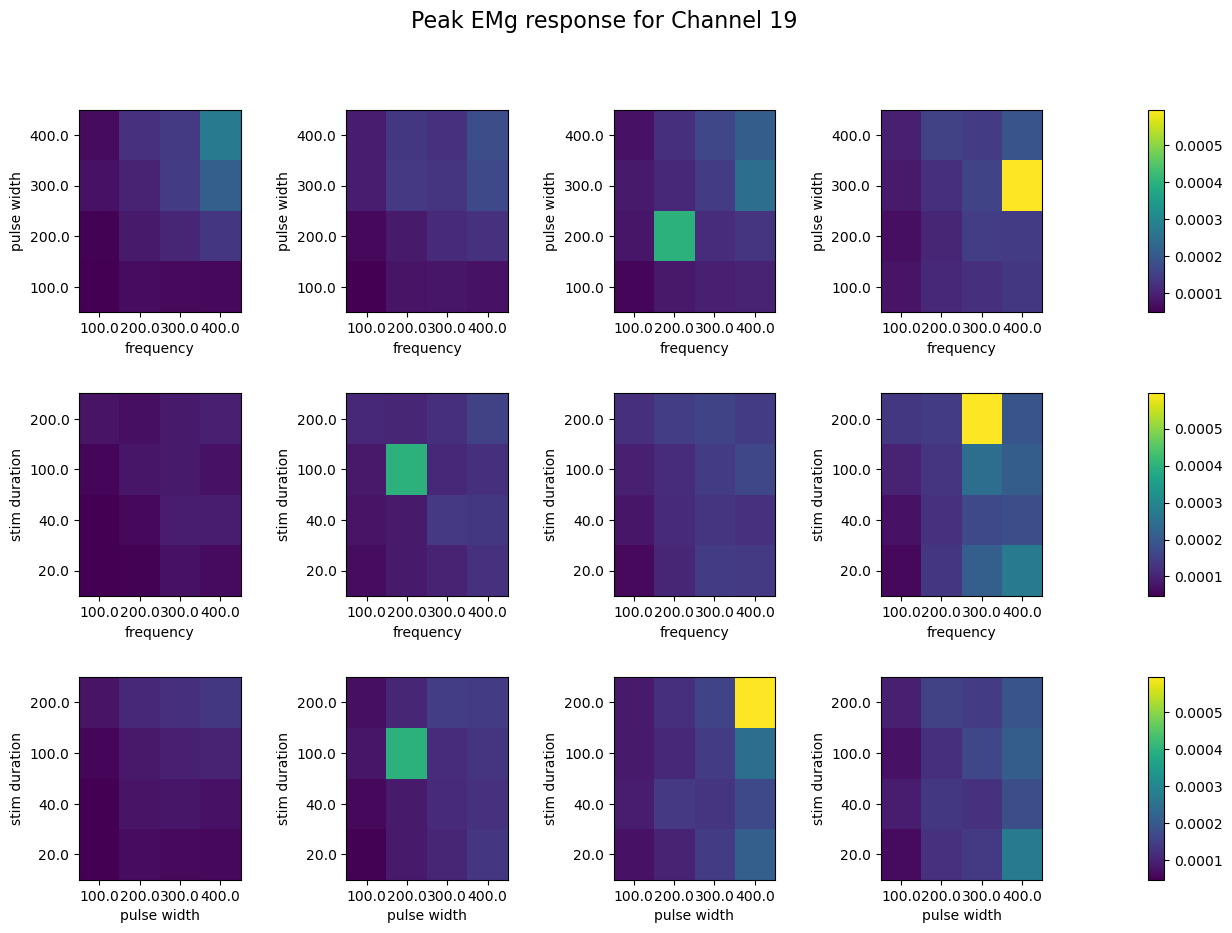

In [196]:
visualize_heatmaps(peak_map, 3, 1, 'Channel 19')

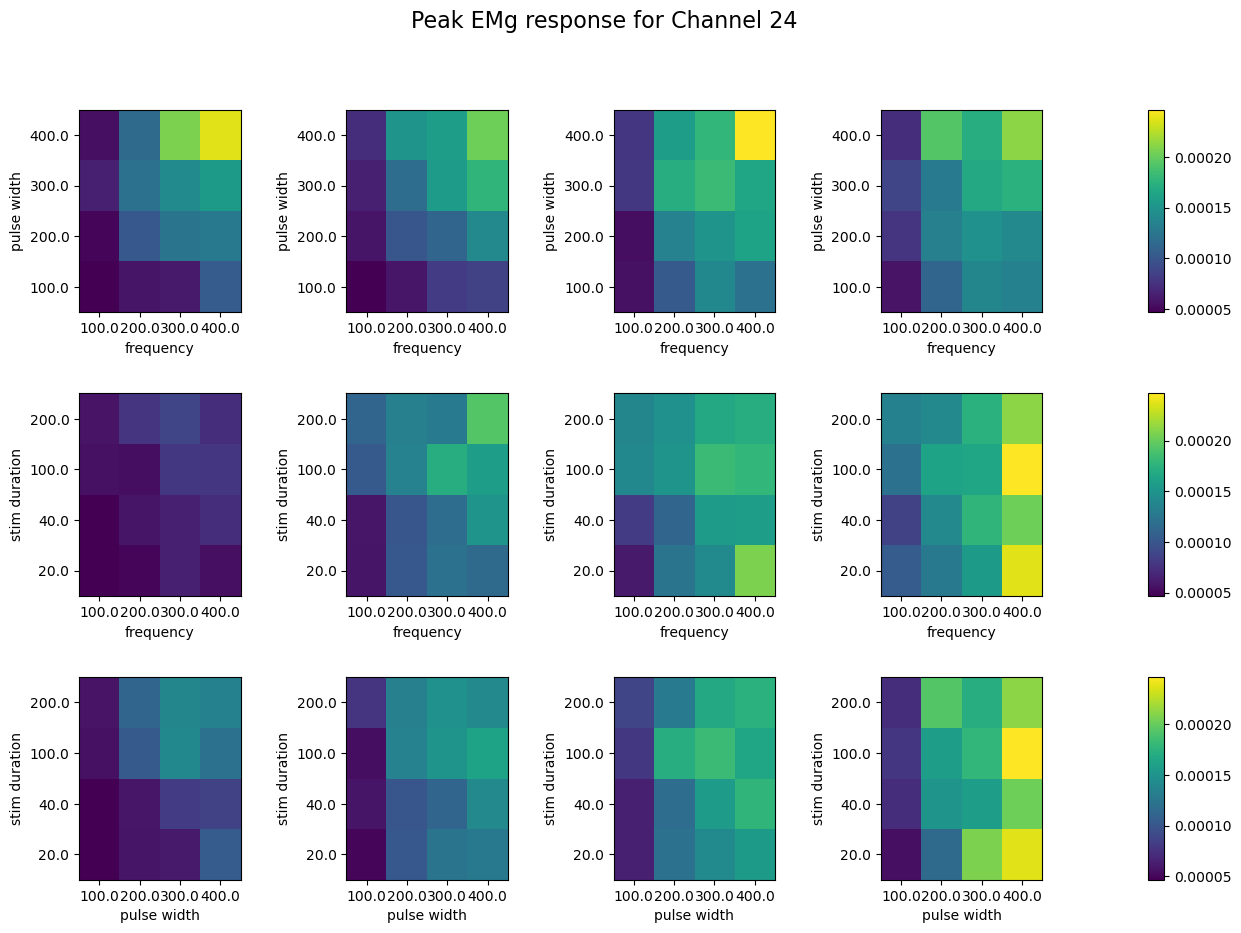

In [197]:
visualize_heatmaps(peak_map, 3, 6, 'Channel 24')

## Experiment #2: Quantitative Validation

To check whether we can separate the temporal and spatial optimization, I will explore whether the top-K neurostim combination of params stays consistent for all coordinnates.

In [198]:
def emg_channel_consistency(map, k, verbose=False):

    emg_map = map[EMG_CHANNEL, :, :, :, :, :]

    top_k_vals = []
    top_k_coords = []

    for i in range(4):
        for j in range(8):

            resp = np.max(emg_map[:, :, :, j, i])
            top_k_vals.append(resp)
            top_k_coords.append((i, j))

            # Sort and slice to keep only the top k elements
            sorted_pairs = sorted(zip(top_k_coords, top_k_vals), key=lambda x: x[1], reverse=True)
            top_k_coords, top_k_vals = zip(*sorted_pairs)  # Unpack sorted pairs
            top_k_coords = list(top_k_coords[:k])  # Convert back to list
            top_k_vals = list(top_k_vals[:k])      # Convert back to list
            '''
            if len(top_k_vals) < k:

                top_k_vals.append(resp)
                top_k_coords.append((i, j))

                top_k_coords, top_k_vals = zip(*sorted(top_k_coords, top_k_vals))
            
            elif len(top_k_vals) >= k and resp > top_k_vals[-1]:

                top_k_vals.append(resp)
                top_k_coords.append(i, j)

                top_k_coords, top_k_vals = zip(*sorted(top_k_coords, top_k_vals))
            '''

    #print(f'best vals: {top_k_vals} and its coordinnates: {top_k_coords}')

    #Traverse combinations of neurostim params, calculate overall consistency
    consistency_score = []
    for pw in range(4):

        for freq in range(4):

            for dur in range(4):

                responses = emg_map[pw, freq, dur, :, :]
                vals = []
                coords = []
                for i in range(4):
                    for j in range(8):
                        coords.append((i, j))
                        vals.append(responses[j,i])
                
                sorted_pairs = sorted(zip(coords, vals), key=lambda x: x[1], reverse=True)
                coords, vals = zip(*sorted_pairs)
                coords = list(coords[:k])

                score = 0.0
                for coord in top_k_coords:
                    if coord in coords:
                        score += 1.0
                consistency_score.append(score / k)

    if verbose:
        print(f'Consistency score for top-{k} coordinnates: {np.mean(consistency_score)}')

    return float(np.mean(consistency_score))


In [199]:
emg_channel_consistency(peak_map, 10, verbose=False)

0.784375

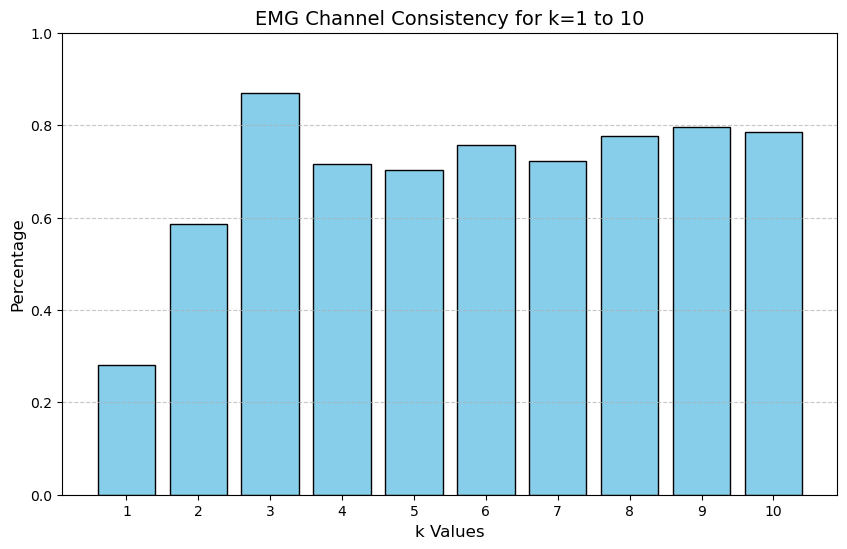

In [200]:
# Assuming peak_map is already defined
k_values = range(1, 11)  # k = 1 to 10
percentages = [emg_channel_consistency(peak_map, k) for k in k_values]

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(k_values, percentages, color='skyblue', edgecolor='black')
plt.xlabel('k Values', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('EMG Channel Consistency for k=1 to 10', fontsize=14)
plt.xticks(k_values)  # Ensure x-ticks match k values
plt.ylim(0, 1)  # Assuming the percentage is in the range 0-100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# PCA analysis

In [69]:
data = peak_map[EMG_CHANNEL, :, :, :, :, :]


In [70]:
# Define the mappings for the column values
pulsewidth_values = [100.0, 200.0, 300.0, 400.0]
frequency_values = [100.0, 200.0, 300.0, 400.0]
stim_duration_values = [20.0, 40.0, 100.0, 200.0]
y_coord_values = list(range(8))
x_coord_values = list(range(4))

# Generate a meshgrid for all combinations of parameters
pulsewidth, frequency, stim_duration, y_coord, x_coord = np.meshgrid(
    pulsewidth_values, frequency_values, stim_duration_values, y_coord_values, x_coord_values, indexing="ij"
)

# Flatten each parameter grid and the data array
pulsewidth_flat = pulsewidth.ravel()
frequency_flat = frequency.ravel()
stim_duration_flat = stim_duration.ravel()
y_coord_flat = y_coord.ravel()
x_coord_flat = x_coord.ravel()
data_flat = data.ravel()

In [71]:
# Create a DataFrame
df = pd.DataFrame({
    "pulsewidth": pulsewidth_flat,
    "frequency": frequency_flat,
    "stim_duration": stim_duration_flat,
    "y_coord": y_coord_flat,
    "x_coord": x_coord_flat,
    "value": data_flat, 
})

# Use the 'value' column as the data for covariance
X = df[["pulsewidth", "frequency", "stim_duration", "y_coord", "x_coord"]]

Z = (X - X.mean()) / X.std()

# Compute the covariance
c = Z.cov()


In [73]:
c

,pulsewidth,frequency,stim_duration,y_coord,x_coord
pulsewidth,1.000000e+00,5.553827e-16,8.790516e-19,-2.320394e-20,3.620676e-20
frequency,5.553827e-16,1.000000e+00,-8.565193e-19,-2.320394e-20,1.446799e-19
stim_duration,8.790516e-19,-8.565193e-19,1.000000e+00,4.972129e-19,-8.793223e-19
y_coord,-2.320394e-20,-2.320394e-20,4.972129e-19,1.000000e+00,1.573187e-19
x_coord,3.620676e-20,1.446799e-19,-8.793223e-19,1.573187e-19,1.000000e+00


In [74]:
eigenvals, eigenvectors = np.linalg.eig(c)
print('Eigen values shape: ', eigenvals.shape)
print('Eigenvectors shape: ', eigenvectors)

Eigen values shape:  (5,)
Eigenvectors shape:  [[ 9.73226482e-01  2.29848245e-01  1.89339380e-04  9.29939422e-05
  -1.52576888e-05]
 [ 2.29847956e-01 -9.73225260e-01 -4.89716414e-04 -4.49476888e-04
   1.49235173e-04]
 [ 3.63799970e-04 -1.54040665e-03 -9.99895740e-01 -1.89465235e-03
   3.53454620e-03]
 [-9.60306874e-06  4.06614408e-05 -1.57762172e-03  6.32433167e-01
   8.83015563e-01]
 [ 1.49843525e-05 -6.34469439e-05  1.43438314e-02  7.74612477e-01
  -4.69330373e-01]]


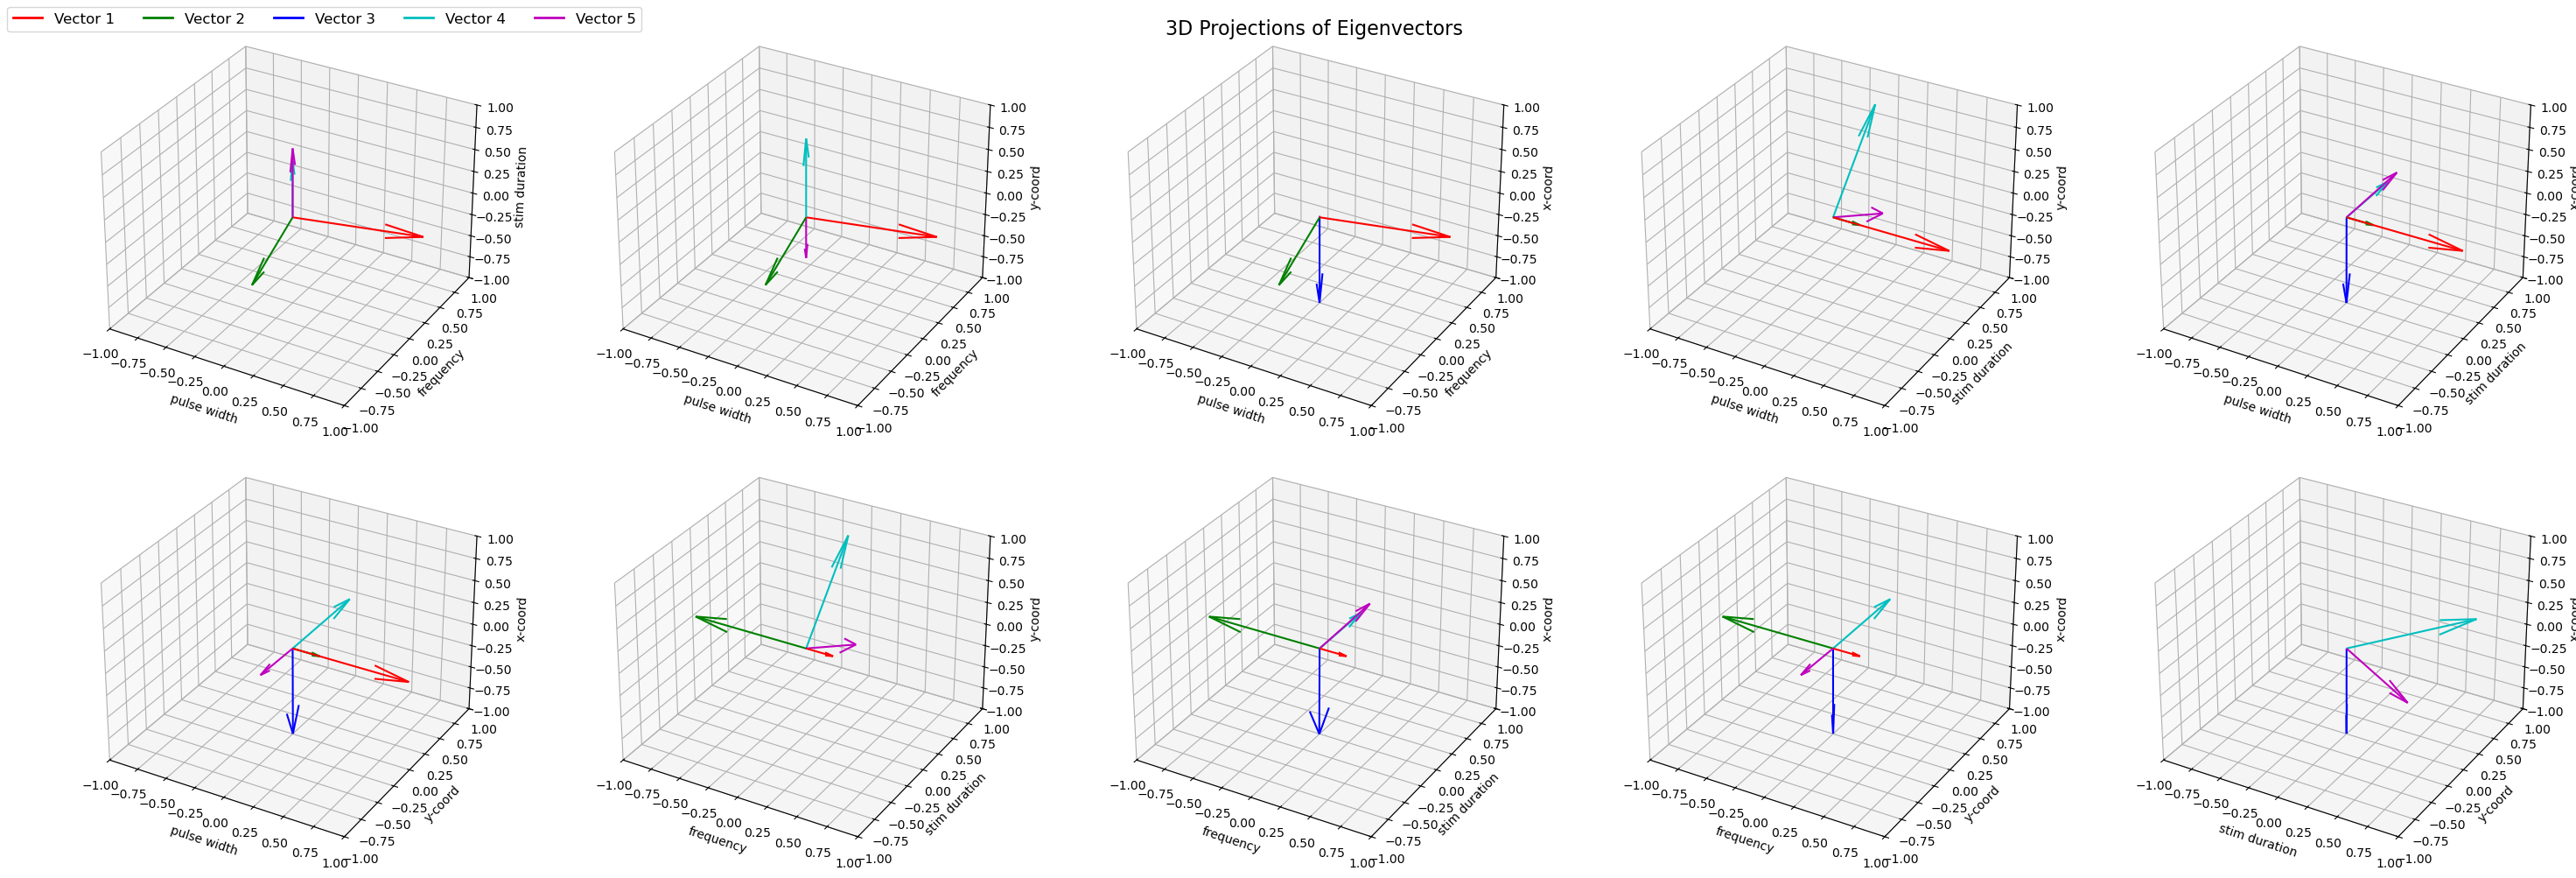

In [89]:
# All unique combinations of 3 dimensions out of 5
combinations = list(itertools.combinations(range(5), 3))

# Set up a grid for subplots
fig = plt.figure(figsize=(30, 10))
grid_rows, grid_cols = 2, 5  # 5 rows and 2 columns

# Color map for eigenvectors
colors = ['r', 'g', 'b', 'c', 'm']
eigenvector_labels = [f'Vector {i + 1}' for i in range(len(colors))]

#Dimension labels
dim_labels = ['pulse width', 'frequency', 'stim duration', 'y-coord', 'x-coord']


# Loop through all combinations and plot
for idx, (i, j, k) in enumerate(combinations):
    ax = fig.add_subplot(grid_rows, grid_cols, idx + 1, projection='3d')
    

    for vec_idx, vec in enumerate(eigenvectors):
        ax.quiver(0, 0, 0, vec[i], vec[j], vec[k], color=colors[vec_idx], label=f'Eigenvector {vec_idx + 1}' if idx == 0 else "")

    ax.set_xlabel(dim_labels[i])
    ax.set_ylabel(dim_labels[j])
    ax.set_zlabel(dim_labels[k])
    #ax.set_title(f'Dimensions: {dim_labels[i]}, {dim_labels[j]}, {dim_labels[k]}')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
# Add a single legend outside the grid for the eigenvector colors
legend_patches = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
fig.legend(
    legend_patches, eigenvector_labels, loc='upper left', ncol=5, fontsize=12
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])
plt.suptitle('3D Projections of Eigenvectors', fontsize=16)
plt.show()

In [96]:
# Index the eigenvalues in descending order 
idx = eigenvals.argsort()[::-1]
# Sort the eigenvalues in descending order 
eigenvalues = eigenvals[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

In [97]:
idx

array([0, 1, 3, 4, 2], dtype=int64)

In [77]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

array([0.2, 0.4, 0.6, 0.8, 1. ])

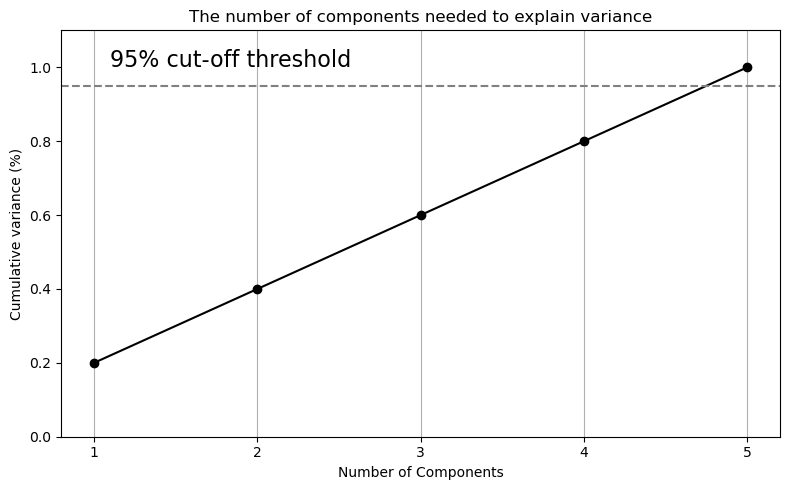

In [105]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 6, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 6, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.show()

In [100]:
n_components = np.argmax(explained_var >= 0.95) + 1
n_components

5

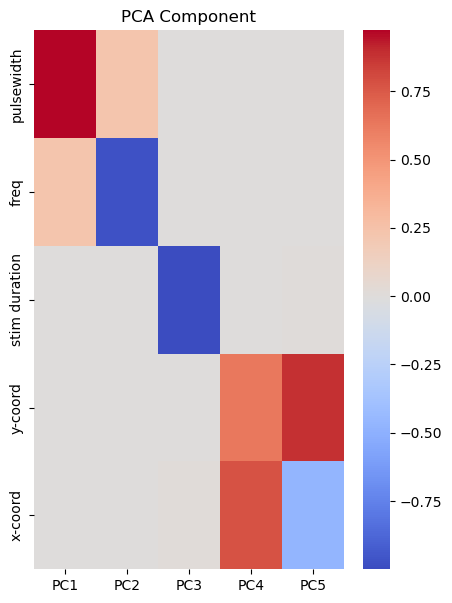

In [101]:
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
                             index = ['pulsewidth', 'freq', 'stim duration', 'y-coord', 'x-coord'],
                             columns = ['PC1','PC2', 'PC3', 'PC4', 'PC5']
                            )

# plotting heatmap
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component, cmap='coolwarm')
plt.title('PCA Component')
plt.show()

# Spatial x Temporal GP

### models archive

In [21]:
class AdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, kernel, d=5, max_degree=3):
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1))
        self.max_degree = max_degree

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [22]:
class TemporoSpatialGP(gpytorch.models.ExactGP):

    def __init__(self, X_train, y_train, likelihood, priorboxes, d_temporal, d_spatial, max_degree=3):
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        self.temporal_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d_temporal, batch_shape=torch.Size([d_temporal]),
                                          lengthscale_prior= priorboxes[0]),
                                          outputscale_prior=priorboxes[1]
        )
        self.temporal_kernel.base_kernel.lengthscale = [1.0]*d_temporal
        self.temporal_kernel.outputscale = [1.0]

        # Spatial: Multivariate kernel
        self.spatial_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d_spatial, batch_shape=torch.Size([d_spatial]),
                                          lengthscale_prior= priorboxes[0]),
                                          outputscale_prior=priorboxes[1]
        )
        self.spatial_kernel.base_kernel.lengthscale = [1.0]*d_spatial
        self.spatial_kernel.outputscale = [1.0]

        
        self.max_degree = max_degree
        self.d_temporal = d_temporal
        self.d_spatial = d_spatial
        self.name = 'SpatioTemporoGP'

    def forward(self, X):
        mean = self.mean_module(X)

        X_temporal = X[:, :self.d_temporal].mT.unsqueeze(-1)
        X_spatial = X[:, self.d_temporal:].mT.unsqueeze(-1)

        temporal_covar = self.temporal_kernel(X_temporal).sum(dim=-3)
        spatial_covar = self.spatial_kernel(X_spatial).sum(dim=-3)

        covar = temporal_covar * spatial_covar #?#

        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [23]:
class StrategicGP(gpytorch.models.ExactGP):

    def __init__(self, X_train, y_train, likelihood, d_temporal, d_spatial, max_degree=3):
        super().__init__(X_train, y_train, likelihood)
        
        #TODO: active_dims corresponds to the indices of the dimensions that will have its covariance computed. Alternative constructions of additive structure can be formulated using this.

        # Temporal: Univariate kernels for efficient computation
        self.temporal_kernels = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_temporal, batch_shape=torch.Size([d_temporal]))
        )
        
        # Spatial: Multivariate kernel
        self.spatial_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_spatial, batch_shape=torch.Size([d_spatial]))
        )
        # Mean module
        self.mean_module = gpytorch.means.ConstantMean()

        self.max_degree = max_degree
        self.d_temporal = d_temporal
        self.d_spatial = d_spatial

    def forward(self, X):
        mean = self.mean_module(X)
        
        # Split X into temporal and spatial components
        X_temporal = X[:, :self.d_temporal].mT.unsqueeze(-1)  # Temporal: d_temporal x n x 1
        X_spatial = X[:, self.d_temporal:]  # Spatial: n x d_spatial

        # Temporal: Sum of univariate RBF kernels
        temporal_covars = self.temporal_kernels(X_temporal)  # Shape: d_temporal x n x n
        temporal_covar = temporal_covars.sum(dim=-3)  # Aggregate additively: n x n

        # Spatial: Multivariate RBF kernel
        spatial_covar = self.spatial_kernel(X_spatial)  # Shape: n x n

        with gpytorch.settings.lazily_evaluate_kernels(False):
            prod_covar = temporal_covar
        # Combine temporal and spatial covariances
        covar = temporal_covar + spatial_covar

        return gpytorch.distributions.MultivariateNormal(mean, covar)


### new attempt (2/5/25)

In [20]:
class TemporoSpatialGP2(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood, 
                 ard_num_dims_group1=3, ard_num_dims_group2=2,
                 lengthscale_priors=None):
        super().__init__(train_x, train_y, likelihood)

        self.temporal_kernel = gpytorch.kernels.MaternKernel(mu=2.5, ard_num_dims=ard_num_dims_group1, active_dims=[0, 1, 2])

        self.spatial_kernel = gpytorch.kernels.MaternKernel(mu=2.5, ard_num_dims=ard_num_dims_group2, active_dims=[3, 4])

        self.mean_module = gpytorch.means.ConstantMean()
        self.likelihood = likelihood
        self.name = 'TemporoSpatialGP'

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.temporal_kernel(x) + self.spatial_kernel(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        

In [21]:
options = None
this_opt=np.array([5.0])

In [22]:
# Setting default options
if options is None:
    options = {}
options.setdefault('n_subjects', 4)
options.setdefault('n_dims', 5)
options.setdefault('dim_sizes', np.array([8,4,4,4,4]))
options.setdefault('which_opt','kappa') 
options.setdefault('rho_low', 0.1)
options.setdefault('rho_high', 6.0) 
options.setdefault('nrnd', 5)
options.setdefault('noise_min', 0.25)
options.setdefault('noise_max', 10)
options.setdefault('MaxQueries', 200) 
options.setdefault('kappa', 5.0) 
options.setdefault('nRep', 30) 

#Params initialization
n_subjects = options['n_subjects']
n_dims = options['n_dims']
DimSearchSpace = np.prod(options['dim_sizes'])
rho_low = options['rho_low']
rho_high = options['rho_high']
nrnd = options['nrnd']
noise_min = options['noise_min']
noise_max = options['noise_max']
MaxQueries = options['MaxQueries']
kappa = options['kappa']
nRep = options['nRep']
total_size = np.prod(options['dim_sizes'])

#Metrics initialization
PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
LOSS = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
Train_time = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)

for s_idx in range(n_subjects):

    # "Ground truth" map
    MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
    mMPm= torch.max(MPm)

    kappa= this_opt[0]

    # Create kernel, likelihood and priors
    # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
    #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
    #The outputscale parameter is parameterized on a log scale to constrain it to be positive
    prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
    likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
    likf.noise= [1.0] 

    #Initialize subject metrics
    perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
    loss = torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_rsq= torch.zeros((nRep), device=DEVICE)
    train_time = torch.zeros((nRep, MaxQueries), device=DEVICE)
    P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
    P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

    for rep_i in range(nRep): # for each repetition

        if rep_i % 10 == 0:
            print('rep: ' + str(rep_i))
        
        MaxSeenResp=0 
        q=0 # query number                                
        order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
        P_max=[]
        hyp=[1.0]*(n_dims+2)

        while q < MaxQueries:

            # Burnout queries
            if q < nrnd:
                P_test[rep_i][q][0]=int(order_this[q])
            
            #Find next point (max of acquisition function)
            else:
        
                if torch.isnan(MapPrediction).any():
                    print('nan in Mean map pred')
                    MapPrediction = torch.nan_to_num(MapPrediction)

                AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                P_test[rep_i][q][0]= NextQuery

            query_elec = P_test[rep_i][q][0]
            sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
            test_respo = sample_resp[np.random.randint(len(sample_resp))]
            test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
            
            #Edge cases handling
            if test_respo < 0:
                test_respo=torch.tensor([0.0001], device= DEVICE)
            if test_respo==0 and q==0: # to avoid division by 0
                test_respo= torch.tensor([0.0001], device=DEVICE)

            
            # done reading response
            P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
            y=(P_test[rep_i][:q+1,1]) 


            # updated maximum response obtained in this round
            if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                MaxSeenResp=torch.max(torch.abs(y))

            # search space position
            x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
            x = x.reshape((len(x),n_dims))

            y=y/MaxSeenResp
            y=y.float()
            
            # Initialization of the model and the constraint of the Gaussian noise 
            if q==0:
                likf.noise= hyp[n_dims+1]
                model = TemporoSpatialGP2(x, y, likf, 3, 2) #model = KernelLearningGP(x, y, likf, partition, kernel_priors=priorboxes)
                #print(f'The model was properly initialized')
                if DEVICE=='cuda':
                    model=model.cuda()
                    likf=likf.cuda() 
            else:
                model.set_train_data(x,y, strict=False)

            start_time = time.time()
            #Training and optimizing model
            model.train()
            likf.train()
            model, likf, l = optimize(model, likf, 10, x, y, verbose= False)

            train_time[rep_i, q] = time.time() - start_time

            #Evaluating model
            model.eval()
            likf.eval()

            with torch.no_grad():
                X_test= ch2xy  
                observed_pred = likf(model(X_test))

            VarianceMap= observed_pred.variance
            MapPrediction= observed_pred.mean

            # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
            Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
            MapPredictionTested=MapPrediction[Tested]
            if len(Tested)==1:
                    BestQuery=Tested
            else:
                BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                if len(BestQuery) > 1:  
                    BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

            # Maximum response at time q 
            P_max.append(BestQuery.item())
            loss[rep_i, q] = l
            q+=1

        # estimate current exploration performance: knowledge of best stimulation point    
        perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
        # estimate current exploitation performance: knowledge of best stimulation point 
        perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

    PP[s_idx,0,0]=perf_explore
    Q[s_idx,0,0] = P_test[:,:,0]
    PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm
    Train_time[s_idx, 0, 0] = train_time
    LOSS[s_idx,0,0] = loss


np.savez('../../output/experiments/'+ model.name+'_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), LOSS= LOSS.detach().cpu().numpy(), Train_time=Train_time.detach().cpu().numpy(), Q = Q.cpu(), this_opt = this_opt, nrnd = nrnd, kappa = kappa)


rep: 0
rep: 10
rep: 20
rep: 0


c:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


rep: 10
rep: 20
rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20


### adding priors

In [31]:
class TemporoSpatialGP2(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood, lengthscale_prior, 
                ard_num_dims_group1=3, ard_num_dims_group2=2):
        super().__init__(train_x, train_y, likelihood)

        scale_prior = gpytorch.priors.SmoothedBoxPrior(a=math.log(0.01**2),b= math.log(100.0**2), sigma=0.01)
        
        self.temporal_kernel = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.MaternKernel( 
                                mu=2.5, 
                                ard_num_dims=ard_num_dims_group1, 
                                active_dims=[0, 1, 2],
                                lengthscale_prior= lengthscale_prior),
                                outputscale_prior= scale_prior)
        self.temporal_kernel.base_kernel.lengthscale = [1.0]*ard_num_dims_group1
        self.temporal_kernel.outputscale=[1.0]

        self.spatial_kernel = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.MaternKernel(
                                mu=2.5, 
                                ard_num_dims=ard_num_dims_group2, 
                                active_dims=[3, 4],
                                lengthscale_prior= lengthscale_prior),
                                outputscale_prior=scale_prior)
        self.spatial_kernel.base_kernel.lengthscale = [1.0]*ard_num_dims_group2
        self.spatial_kernel.outputscale=[1.0]

        self.mean_module = gpytorch.means.ConstantMean()
        self.likelihood = likelihood
        self.name = 'TemporoSpatialGP'

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.temporal_kernel(x) + self.spatial_kernel(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [29]:
options = None
this_opt=np.array([5.0])

In [32]:
# Setting default options
if options is None:
    options = {}
options.setdefault('n_subjects', 4)
options.setdefault('n_dims', 5)
options.setdefault('dim_sizes', np.array([8,4,4,4,4]))
options.setdefault('which_opt','kappa') 
options.setdefault('rho_low', 0.1)
options.setdefault('rho_high', 6.0) 
options.setdefault('nrnd', 5)
options.setdefault('noise_min', 0.25)
options.setdefault('noise_max', 10)
options.setdefault('MaxQueries', 200) 
options.setdefault('kappa', 5.0) 
options.setdefault('nRep', 30) 

#Params initialization
n_subjects = options['n_subjects']
n_dims = options['n_dims']
DimSearchSpace = np.prod(options['dim_sizes'])
rho_low = options['rho_low']
rho_high = options['rho_high']
nrnd = options['nrnd']
noise_min = options['noise_min']
noise_max = options['noise_max']
MaxQueries = options['MaxQueries']
kappa = options['kappa']
nRep = options['nRep']
total_size = np.prod(options['dim_sizes'])

#Metrics initialization
PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
LOSS = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
Train_time = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)

for s_idx in range(n_subjects):

    # "Ground truth" map
    MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
    mMPm= torch.max(MPm)

    kappa= this_opt[0]

    # Create kernel, likelihood and priors
    # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
    #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
    #The outputscale parameter is parameterized on a log scale to constrain it to be positive
    lengthscale_prior= gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low),b= math.log(rho_high), sigma=0.01) 
    prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
    likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
    likf.noise= [1.0] 

    #Initialize subject metrics
    perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
    loss = torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_rsq= torch.zeros((nRep), device=DEVICE)
    train_time = torch.zeros((nRep, MaxQueries), device=DEVICE)
    P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
    P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

    for rep_i in range(nRep): # for each repetition

        if rep_i % 10 == 0:
            print('rep: ' + str(rep_i))
        
        MaxSeenResp=0 
        q=0 # query number                                
        order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
        P_max=[]
        hyp=[1.0]*(n_dims+2)

        while q < MaxQueries:

            # Burnout queries
            if q < nrnd:
                P_test[rep_i][q][0]=int(order_this[q])
            
            #Find next point (max of acquisition function)
            else:
        
                if torch.isnan(MapPrediction).any():
                    print('nan in Mean map pred')
                    MapPrediction = torch.nan_to_num(MapPrediction)

                AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                P_test[rep_i][q][0]= NextQuery

            query_elec = P_test[rep_i][q][0]
            sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
            test_respo = sample_resp[np.random.randint(len(sample_resp))]
            test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
            
            #Edge cases handling
            if test_respo < 0:
                test_respo=torch.tensor([0.0001], device= DEVICE)
            if test_respo==0 and q==0: # to avoid division by 0
                test_respo= torch.tensor([0.0001], device=DEVICE)

            
            # done reading response
            P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
            y=(P_test[rep_i][:q+1,1]) 


            # updated maximum response obtained in this round
            if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                MaxSeenResp=torch.max(torch.abs(y))

            # search space position
            x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
            x = x.reshape((len(x),n_dims))

            y=y/MaxSeenResp
            y=y.float()
            
            # Initialization of the model and the constraint of the Gaussian noise 
            if q==0:
                likf.noise= hyp[n_dims+1]
                model = TemporoSpatialGP2(x, y, likf, lengthscale_prior, 3, 2) #model = KernelLearningGP(x, y, likf, partition, kernel_priors=priorboxes)
                #print(f'The model was properly initialized')
                if DEVICE=='cuda':
                    model=model.cuda()
                    likf=likf.cuda() 
            else:
                model.set_train_data(x,y, strict=False)

            start_time = time.time()
            #Training and optimizing model
            model.train()
            likf.train()
            model, likf, l = optimize(model, likf, 10, x, y, verbose= False)

            train_time[rep_i, q] = time.time() - start_time

            #Evaluating model
            model.eval()
            likf.eval()

            with torch.no_grad():
                X_test= ch2xy  
                observed_pred = likf(model(X_test))

            VarianceMap= observed_pred.variance
            MapPrediction= observed_pred.mean

            # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
            Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
            MapPredictionTested=MapPrediction[Tested]
            if len(Tested)==1:
                    BestQuery=Tested
            else:
                BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                if len(BestQuery) > 1:  
                    BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

            # Maximum response at time q 
            P_max.append(BestQuery.item())
            loss[rep_i, q] = l
            q+=1

        # estimate current exploration performance: knowledge of best stimulation point    
        perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
        # estimate current exploitation performance: knowledge of best stimulation point 
        perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

    PP[s_idx,0,0]=perf_explore
    Q[s_idx,0,0] = P_test[:,:,0]
    PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm
    Train_time[s_idx, 0, 0] = train_time
    LOSS[s_idx,0,0] = loss


np.savez('../../output/experiments/'+ model.name+'_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), LOSS= LOSS.detach().cpu().numpy(), Train_time=Train_time.detach().cpu().numpy(), Q = Q.cpu(), this_opt = this_opt, nrnd = nrnd, kappa = kappa)


rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20
rep: 0
rep: 10
rep: 20


### Efficient additive structure implementation

In [75]:
class EfficientTemporoSpatialGP(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood, lengthscale_prior, 
                 group_dims = [[0, 1, 2], [3, 4]]):
        super().__init__(train_x, train_y, likelihood)

        self.scale_prior = gpytorch.priors.SmoothedBoxPrior(a=math.log(0.01**2),b= math.log(100.0**2), sigma=0.01)
        self.group_dims=group_dims
        self.num_groups = len(group_dims)
        self.ard_num_dims_list = [len(x) for x in group_dims]

        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.MaternKernel(
                                mu=2.5,
                                batch_shape=torch.Size([self.num_groups]),
                                ard_num_dims= 1,
                                lengthscale_prior = lengthscale_prior
                                ),
                                batch_shape=torch.Size([self.num_groups]),
                                outputscale_prior= self.scale_prior)
        

        self.covar_module.outputscale = [1.0]
        print(f'covar_module: {self.covar_module}')
        #self.covar_module.base_kernel.lengthscale = [1.0]*5
        #self.covar_module.outputscale=[1.0]

        self.mean_module = gpytorch.means.ConstantMean()
        self.likelihood = likelihood
        self.name = 'EfficientTemporoSpatialGP'

    def forward(self, x):
        mean_x = self.mean_module(x)

        #print([x[:, dims] for dims in self.group_dims])

        #batched_x = torch.cat([x[:, dims].unsqueeze(0) for dims in self.group_dims], dim=0) #torch.stack([x[:, dims] for dims in self.group_dims], dim=0)
        #covar_x = self.covar_module(batched_x).sum(dim=0) # Sum across groups
        covars = [self.covar_module(x[:, dims]) for dims in self.group_dims]
        covar_x = sum(covars)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [50]:
options = None
this_opt=np.array([5.0])

In [76]:
# Setting default options
if options is None:
    options = {}
options.setdefault('n_subjects', 4)
options.setdefault('n_dims', 5)
options.setdefault('dim_sizes', np.array([8,4,4,4,4]))
options.setdefault('which_opt','kappa') 
options.setdefault('rho_low', 0.1)
options.setdefault('rho_high', 6.0) 
options.setdefault('nrnd', 5)
options.setdefault('noise_min', 0.25)
options.setdefault('noise_max', 10)
options.setdefault('MaxQueries', 200) 
options.setdefault('kappa', 5.0) 
options.setdefault('nRep', 30) 

#Params initialization
n_subjects = options['n_subjects']
n_dims = options['n_dims']
DimSearchSpace = np.prod(options['dim_sizes'])
rho_low = options['rho_low']
rho_high = options['rho_high']
nrnd = options['nrnd']
noise_min = options['noise_min']
noise_max = options['noise_max']
MaxQueries = options['MaxQueries']
kappa = options['kappa']
nRep = options['nRep']
total_size = np.prod(options['dim_sizes'])

#Metrics initialization
PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
LOSS = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
Train_time = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)

for s_idx in range(n_subjects):

    # "Ground truth" map
    MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
    mMPm= torch.max(MPm)

    kappa= this_opt[0]

    # Create kernel, likelihood and priors
    # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
    #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
    #The outputscale parameter is parameterized on a log scale to constrain it to be positive
    lengthscale_prior= gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low),b= math.log(rho_high), sigma=0.01) 
    prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
    likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
    likf.noise= [1.0] 

    #Initialize subject metrics
    perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
    loss = torch.zeros((nRep, MaxQueries), device=DEVICE)
    perf_rsq= torch.zeros((nRep), device=DEVICE)
    train_time = torch.zeros((nRep, MaxQueries), device=DEVICE)
    P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
    P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

    for rep_i in range(nRep): # for each repetition

        if rep_i % 10 == 0:
            print('rep: ' + str(rep_i))
        
        MaxSeenResp=0 
        q=0 # query number                                
        order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
        P_max=[]
        hyp=[1.0]*(n_dims+2)

        while q < MaxQueries:

            # Burnout queries
            if q < nrnd:
                P_test[rep_i][q][0]=int(order_this[q])
            
            #Find next point (max of acquisition function)
            else:
        
                if torch.isnan(MapPrediction).any():
                    print('nan in Mean map pred')
                    MapPrediction = torch.nan_to_num(MapPrediction)

                AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                P_test[rep_i][q][0]= NextQuery

            query_elec = P_test[rep_i][q][0]
            sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
            test_respo = sample_resp[np.random.randint(len(sample_resp))]
            test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
            
            #Edge cases handling
            if test_respo < 0:
                test_respo=torch.tensor([0.0001], device= DEVICE)
            if test_respo==0 and q==0: # to avoid division by 0
                test_respo= torch.tensor([0.0001], device=DEVICE)

            
            # done reading response
            P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
            y=(P_test[rep_i][:q+1,1]) 


            # updated maximum response obtained in this round
            if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                MaxSeenResp=torch.max(torch.abs(y))

            # search space position
            x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
            x = x.reshape((len(x),n_dims))

            y=y/MaxSeenResp
            y=y.float()
            
            # Initialization of the model and the constraint of the Gaussian noise 
            if q==0:
                likf.noise= hyp[n_dims+1]
                model = EfficientTemporoSpatialGP(x, y, likf, lengthscale_prior, [[0, 1, 2], [3, 4]])
                #print(f'The model was properly initialized')
                if DEVICE=='cuda':
                    model=model.cuda()
                    likf=likf.cuda() 
            else:
                model.set_train_data(x,y, strict=False)

            start_time = time.time()
            #Training and optimizing model
            model.train()
            likf.train()
            model, likf, l = optimize(model, likf, 10, x, y, verbose= False)

            train_time[rep_i, q] = time.time() - start_time

            #Evaluating model
            model.eval()
            likf.eval()

            with torch.no_grad():
                X_test= ch2xy  
                observed_pred = likf(model(X_test))

            VarianceMap= observed_pred.variance
            MapPrediction= observed_pred.mean

            # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
            Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
            MapPredictionTested=MapPrediction[Tested]
            if len(Tested)==1:
                    BestQuery=Tested
            else:
                BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                if len(BestQuery) > 1:  
                    BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

            # Maximum response at time q 
            P_max.append(BestQuery.item())
            loss[rep_i, q] = l
            q+=1

        # estimate current exploration performance: knowledge of best stimulation point    
        perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
        # estimate current exploitation performance: knowledge of best stimulation point 
        perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

    PP[s_idx,0,0]=perf_explore
    Q[s_idx,0,0] = P_test[:,:,0]
    PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm
    Train_time[s_idx, 0, 0] = train_time
    LOSS[s_idx,0,0] = loss


np.savez('../../output/experiments/'+ model.name+'_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), LOSS= LOSS.detach().cpu().numpy(), Train_time=Train_time.detach().cpu().numpy(), Q = Q.cpu(), this_opt = this_opt, nrnd = nrnd, kappa = kappa)


rep: 0
covar_module: ScaleKernel(
  (base_kernel): MaternKernel(
    (lengthscale_prior): SmoothedBoxPrior()
    (raw_lengthscale_constraint): Positive()
  )
  (outputscale_prior): SmoothedBoxPrior()
  (raw_outputscale_constraint): Positive()
)
[tensor([[200., 300.,  20.]], device='cuda:0'), tensor([[8., 2.]], device='cuda:0')]


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

### Unit Testing

The current implementation of SpatioTemporalGP does not outcompute a simpleGP on the forward pass.


In [134]:

synthetic = synthetic_datasets.SyntheticTestFun('hartmann', 6, 0.0)
# Mock data and priorboxes for testing
X_train = torch.rand(100, 6)  # 100 samples, 5 input dimensions
y_train = synthetic.f.forward(X_train)     # 100 target values
d_temporal = 3
d_spatial = 3
priorboxes = [gpytorch.priors.NormalPrior(1.0, 0.5), gpytorch.priors.NormalPrior(2.0, 0.5)]
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()

# TemporoSpatialGP class assumed to be already defined

class TestTemporoSpatialGP(unittest.TestCase):

    def test_forward_output_shape(self):
        """Test if the forward method returns the correct output shape."""
        model = TemporoSpatialGP(X_train, y_train, likelihood, priorboxes, d_temporal, d_spatial)
        model.eval()
        
        # Forward pass
        output = model(X_train)
        
        # Check output mean and covariance shapes
        self.assertEqual(output.mean.shape, torch.Size([X_train.shape[0]]),
                         "Output mean shape mismatch.")
        self.assertEqual(output.covariance_matrix.shape, torch.Size([X_train.shape[0], X_train.shape[0]]),
                         "Output covariance shape mismatch.")

    def test_computation_time(self):
        """Test and compare the computation time between a simple GP and TemporoSpatialGP."""
        # Define a simple GP model
        class SimpleGP(gpytorch.models.ExactGP):
            def __init__(self, X_train, y_train, likelihood):
                super().__init__(X_train, y_train, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=priorboxes[0]), outputscale_prior=priorboxes[1])
                #self.covar_module.base_kernel.lengthscale = [1.0]*5
                
                self.covar_module.outputscale = [1.0]

            def forward(self, X):
                mean = self.mean_module(X)
                covar = self.covar_module(X)
                return gpytorch.distributions.MultivariateNormal(mean, covar)


        simple_gp = SimpleGP(X_train, y_train, likelihood)
        temporospatial_gp = TemporoSpatialGP(X_train, y_train, likelihood2, priorboxes, d_temporal, d_spatial)# AdditiveKernelGP(X_train, y_train, 5)#AdditiveGP(X_train, y_train, likelihood2, 5, max_degree=3) 
        
        # Measure computation time for forward pass
        start_simple = time.time()
        simple_gp(X_train)
        end_simple = time.time()

        start_temporal = time.time()
        temporospatial_gp(X_train)
        end_temporal = time.time()

        print("Simple GP computation time:", end_simple - start_simple)
        print("TemporoSpatialGP computation time:", end_temporal - start_temporal)

        # Assert that TemporoSpatialGP doesn't take excessively longer
        self.assertLess(end_temporal - start_temporal,(end_simple - start_simple),
                        "TemporoSpatialGP is too slow compared to SimpleGP.")

    def test_kernel_parameters(self):
        """Verify that the lengthscales and outputscales of each kernel are properly defined."""
        model = TemporoSpatialGP(X_train, y_train, likelihood, priorboxes, d_temporal, d_spatial)

        # Check temporal kernel parameters
        temporal_lengthscale = model.temporal_kernel.base_kernel.lengthscale
        temporal_outputscale = model.temporal_kernel.outputscale

        self.assertTrue(torch.allclose(temporal_lengthscale, torch.tensor([1.0] * d_temporal)),
                        "Temporal kernel lengthscale mismatch.")
        self.assertTrue(torch.allclose(temporal_outputscale, torch.tensor([1.0])),
                        "Temporal kernel outputscale mismatch.")

        # Check spatial kernel parameters
        spatial_lengthscale = model.spatial_kernel.base_kernel.lengthscale
        spatial_outputscale = model.spatial_kernel.outputscale

        self.assertTrue(torch.allclose(spatial_lengthscale, torch.tensor([1.0] * d_spatial)),
                        "Spatial kernel lengthscale mismatch.")
        self.assertTrue(torch.allclose(spatial_outputscale, torch.tensor([1.0])),
                        "Spatial kernel outputscale mismatch.")

    def test_backward_pass(self):
        """Compare the backward pass computation time of SimpleGP and TemporoSpatialGP."""
        # Define a simple GP model
        class SimpleGP(gpytorch.models.ExactGP):
            def __init__(self, X_train, y_train, likelihood):
                super().__init__(X_train, y_train, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

            def forward(self, X):
                mean = self.mean_module(X)
                covar = self.covar_module(X)
                return gpytorch.distributions.MultivariateNormal(mean, covar)

        simple_gp = SimpleGP(X_train, y_train, likelihood)
        temporospatial_gp = TemporoSpatialGP(X_train, y_train, likelihood2, priorboxes, d_temporal, d_spatial)

        # Enable gradient computation for backward pass
        simple_gp.train()
        temporospatial_gp.train()

        # SimpleGP backward pass
        start_simple = time.time()
        optimize(simple_gp, likelihood, 100, X_train, y_train, verbose=False)
        end_simple = time.time()

        # TemporoSpatialGP backward pass
        start_temporal = time.time()
        optimize(temporospatial_gp, likelihood2, 100, X_train, y_train, verbose=False)
        end_temporal = time.time()

        print("Simple GP backward pass time:", end_simple - start_simple)
        print("TemporoSpatialGP backward pass time:", end_temporal - start_temporal)

        # Assert that TemporoSpatialGP doesn't take excessively longer for backward pass
        self.assertLess(end_temporal - start_temporal, (end_simple - start_simple),
                        "TemporoSpatialGP backward pass is too slow compared to SimpleGP.")

unittest.main(argv=[''], exit=False)

c:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
FFc:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
..
FAIL: test_backward_pass (__main__.TestTemporoSpatialGP.test_backward_pass)
Compare the backward pass computation time of SimpleGP and TemporoSpatialGP.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\mauri\AppData\Local\Temp\ipykernel_17280\1621797079.py", line 123, in test_backward_pass
    self.assertLess(end_temporal - start_temporal, (end_simple - start

Simple GP backward pass time: 0.22739887237548828
TemporoSpatialGP backward pass time: 0.7397499084472656
Simple GP computation time: 0.0009927749633789062
TemporoSpatialGP computation time: 0.002182483673095703


The same goes for the AdditiveGP implementation on their archive

In [136]:
synthetic = synthetic_datasets.SyntheticTestFun('hartmann', 6, 0.0)
# Mock data and priorboxes for testing
X_train = torch.rand(100, 6)  # 100 samples, 5 input dimensions
y_train = synthetic.f.forward(X_train)     # 100 target values
d_temporal = 3
d_spatial = 3
priorboxes = [gpytorch.priors.NormalPrior(1.0, 0.5), gpytorch.priors.NormalPrior(2.0, 0.5)]
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()

class TestAdditiveGP(unittest.TestCase):

    def test_forward_output_shape(self):
        """Test if the forward method returns the correct output shape."""
        model = AdditiveGP(X_train, y_train, likelihood, priorboxes, d_temporal, d_spatial)
        model.eval()
        
        # Forward pass
        output = model(X_train)
        
        # Check output mean and covariance shapes
        self.assertEqual(output.mean.shape, torch.Size([X_train.shape[0]]),
                         "Output mean shape mismatch.")
        self.assertEqual(output.covariance_matrix.shape, torch.Size([X_train.shape[0], X_train.shape[0]]),
                         "Output covariance shape mismatch.")

    def test_computation_time(self):
        """Test and compare the computation time between a simple GP and AdditiveGP."""
        # Define a simple GP model
        class SimpleGP(gpytorch.models.ExactGP):
            def __init__(self, X_train, y_train, likelihood):
                super().__init__(X_train, y_train, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=priorboxes[0]), outputscale_prior=priorboxes[1])
                #self.covar_module.base_kernel.lengthscale = [1.0]*5
                
                self.covar_module.outputscale = [1.0]

            def forward(self, X):
                mean = self.mean_module(X)
                covar = self.covar_module(X)
                return gpytorch.distributions.MultivariateNormal(mean, covar)


        simple_gp = SimpleGP(X_train, y_train, likelihood)
        additive_gp = AdditiveGP(X_train, y_train, likelihood2, priorboxes, d_temporal, d_spatial)# AdditiveKernelGP(X_train, y_train, 5)#AdditiveGP(X_train, y_train, likelihood2, 5, max_degree=3) 
        
        # Measure computation time for forward pass
        start_simple = time.time()
        simple_gp(X_train)
        end_simple = time.time()

        start_temporal = time.time()
        additive_gp(X_train)
        end_temporal = time.time()

        print("Simple GP computation time:", end_simple - start_simple)
        print("AdditiveGP computation time:", end_temporal - start_temporal)

        # Assert that AdditiveGP doesn't take excessively longer
        self.assertLess(end_temporal - start_temporal,(end_simple - start_simple),
                        "AdditiveGP is too slow compared to SimpleGP.")

    def test_kernel_parameters(self):
        """Verify that the lengthscales and outputscales of each kernel are properly defined."""
        model = AdditiveGP(X_train, y_train, likelihood, priorboxes, d_temporal, d_spatial)

        # Check temporal kernel parameters
        temporal_lengthscale = model.temporal_kernel.base_kernel.lengthscale
        temporal_outputscale = model.temporal_kernel.outputscale

        self.assertTrue(torch.allclose(temporal_lengthscale, torch.tensor([1.0] * d_temporal)),
                        "Temporal kernel lengthscale mismatch.")
        self.assertTrue(torch.allclose(temporal_outputscale, torch.tensor([1.0])),
                        "Temporal kernel outputscale mismatch.")

        # Check spatial kernel parameters
        spatial_lengthscale = model.spatial_kernel.base_kernel.lengthscale
        spatial_outputscale = model.spatial_kernel.outputscale

        self.assertTrue(torch.allclose(spatial_lengthscale, torch.tensor([1.0] * d_spatial)),
                        "Spatial kernel lengthscale mismatch.")
        self.assertTrue(torch.allclose(spatial_outputscale, torch.tensor([1.0])),
                        "Spatial kernel outputscale mismatch.")

    def test_backward_pass(self):
        """Compare the backward pass computation time of SimpleGP and AdditiveGP."""
        # Define a simple GP model
        class SimpleGP(gpytorch.models.ExactGP):
            def __init__(self, X_train, y_train, likelihood):
                super().__init__(X_train, y_train, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

            def forward(self, X):
                mean = self.mean_module(X)
                covar = self.covar_module(X)
                return gpytorch.distributions.MultivariateNormal(mean, covar)

        simple_gp = SimpleGP(X_train, y_train, likelihood)
        additive_gp = AdditiveGP(X_train, y_train, likelihood2, priorboxes, d_temporal, d_spatial)

        # Enable gradient computation for backward pass
        simple_gp.train()
        additive_gp.train()

        # SimpleGP backward pass
        start_simple = time.time()
        optimize(simple_gp, likelihood, 100, X_train, y_train, verbose=False)
        end_simple = time.time()

        # TemporoSpatialGP backward pass
        start_temporal = time.time()
        optimize(additive_gp, likelihood2, 100, X_train, y_train, verbose=False)
        end_temporal = time.time()

        print("Simple GP backward pass time:", end_simple - start_simple)
        print("AdditiveGP backward pass time:", end_temporal - start_temporal)

        # Assert that AdditiveGP doesn't take excessively longer for backward pass
        self.assertLess(end_temporal - start_temporal, (end_simple - start_simple),
                        "AdditiveGP backward pass is too slow compared to SimpleGP.")

unittest.main(argv=[''], exit=False)

EEEEc:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
FFc:\Users\mauri\miniconda3\envs\GPBO\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
..
ERROR: test_backward_pass (__main__.TestAdditiveGP.test_backward_pass)
Compare the backward pass computation time of SimpleGP and AdditiveGP.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\mauri\AppData\Local\Temp\ipykernel_17280\1126167103.py", line 101, in test_backward_pass
    additive_gp = AdditiveGP(X_train, y_train, likelihood2, priorboxes, d_tem

Simple GP backward pass time: 0.23256325721740723
TemporoSpatialGP backward pass time: 0.7358973026275635
Simple GP computation time: 0.0
TemporoSpatialGP computation time: 0.002521038055419922


## KernelLearning GP

In [177]:
# Define the additive structure kernel
class KernelLearningGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, dims_partition, kernel_priors=None, n_dims=5, lengthscales=None, output_scale=None):
        super().__init__(train_x, train_y, likelihood)

        self.kernels = []
        for idx, partition in enumerate(dims_partition):
            if kernel_priors:
                matk = gpytorch.kernels.MaternKernel(nu=2.5, active_dims=dims_partition[idx], ard_num_dims= n_dims, lengthscale_prior= kernel_priors[0]) #TODO: Need for ard_num_dims= n_dims? 
                matk_scaled = gpytorch.kernels.ScaleKernel(matk , outputscale_prior=kernel_priors[1])
                matk_scaled.base_kernel.lengthscale= [1.0]*n_dims
                matk_scaled.outputscale = [1.0]
                self.kernels.append(matk_scaled)

            elif lengthscales:
                matk = gpytorch.kernels.MaternKernel(nu=2.5, active_dims=dims_partition[idx], ard_num_dims= n_dims)
                matk_scaled = gpytorch.kernels.ScaleKernel(matk)
                matk_scaled.base_kernel.lengthscale = lengthscales
                matk_scaled.outputscale= output_scale
                self.kernels.append(matk_scaled)

            else:
                self.kernels.append(gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, active_dims=dims_partition[idx], ard_num_dims= n_dims)))
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.likelihood = likelihood
        self.n_dims = n_dims

    def forward(self, x):
        mean_x = self.mean_module(x)
        kernel_sum = reduce(lambda a, b: a + b, self.kernels)
        covar_x = kernel_sum(x)
        #covar_x = self.kernels[0](x)
        #for k in self.kernels[1:]:
        #    covar_x += k(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    

In [62]:
this_opt=np.array([20])
options = None

In [171]:
def partition_helper(arr):
    result = [[i for i, val in enumerate(arr) if val == y] for y in arr]
    result = [sublist for sublist in result if sublist]
    unique_lst = []
    for sublist in result:
        if sublist not in unique_lst:
            unique_lst.append(sublist)

    return unique_lst

def lengthscales_helper(model: KernelLearningGP, old: list):

    ordered_lengthscales, ordered_outputscales = [], []

    for dim in range(model.n_dims):

        for idx, sublist in enumerate(old):

            if dim in sublist:
                
                ordered_lengthscales.append(model.kernels[idx].base_kernel.lengthscale[0]) #TODO: affected by ard_num_dims model.covar_module.base_kernel.lengthscale[idx][dim]
                ordered_outputscales.append(model.kernels[idx].outputscale)

    return ordered_lengthscales, ordered_outputscales


In [178]:
def neurostim_kernel_learning_BO(this_opt, options=None):
    # Setting default options
    if options is None:
        options = {}
    options.setdefault('n_subjects', 4)
    options.setdefault('n_dims', 5)
    options.setdefault('dim_sizes', np.array([8,4,4,4,4]))
    options.setdefault('which_opt','kappa') 
    options.setdefault('rho_low', 0.1)
    options.setdefault('rho_high', 6.0) 
    options.setdefault('nrnd', 5)
    options.setdefault('noise_min', 0.25)
    options.setdefault('noise_max', 10)
    options.setdefault('MaxQueries', 200) 
    options.setdefault('kappa', 20) 
    options.setdefault('nRep', 75) 

    #Params initialization
    n_subjects = options['n_subjects']
    n_dims = options['n_dims']
    DimSearchSpace = np.prod(options['dim_sizes'])
    rho_low = options['rho_low']
    rho_high = options['rho_high']
    nrnd = options['nrnd']
    noise_min = options['noise_min']
    noise_max = options['noise_max']
    MaxQueries = options['MaxQueries']
    kappa = options['kappa']
    nRep = options['nRep']
    total_size = np.prod(options['dim_sizes'])

    #Metrics initialization
    PP = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
    PP_t = torch.zeros((n_subjects,1, len(this_opt),nRep, MaxQueries), device=DEVICE)
    Q = torch.zeros((n_subjects,1,len(this_opt),nRep, MaxQueries), device=DEVICE)
    Train_time = []
    Choose_time = []

    for s_idx in range(n_subjects):

        # "Ground truth" map
        MPm= torch.mean(peak_resp[:, s_idx], axis = 0)
        mMPm= torch.max(MPm)
        train_time = []
        choose_time = []

        kappa= this_opt[0]

        # Create kernel, likelihood and priors
        # Put a  prior on the two lengthscale hyperparameters, the variance and the noise
        #The lengthscale parameter is parameterized on a log scale to constrain it to be positive
        #The outputscale parameter is parameterized on a log scale to constrain it to be positive
        priorbox= gpytorch.priors.SmoothedBoxPrior(a=math.log(rho_low),b= math.log(rho_high), sigma=0.01) 
        priorbox2= gpytorch.priors.SmoothedBoxPrior(a=math.log(0.01**2),b= math.log(100.0**2), sigma=0.01) # std 
        priorboxes = [priorbox, priorbox2]
        prior_lik= gpytorch.priors.SmoothedBoxPrior(a=noise_min**2,b= noise_max**2, sigma=0.01) # gaussian noise variance
        likf= gpytorch.likelihoods.GaussianLikelihood(noise_prior= prior_lik)
        likf.noise= [1.0] 

        #Initialize subject metrics
        perf_explore= torch.zeros((nRep, MaxQueries), device=DEVICE)
        perf_exploit= torch.zeros((nRep, MaxQueries), device=DEVICE)
        perf_rsq= torch.zeros((nRep), device=DEVICE)
        P_test =  torch.zeros((nRep, MaxQueries, 2), device=DEVICE)
        P_max_all_temp= torch.zeros((nRep, MaxQueries), device=DEVICE)

        for rep_i in range(nRep): # for each repetition

            if rep_i % 10 == 0:
                print('rep: ' + str(rep_i))
            
            MaxSeenResp=0 
            q=0 # query number                                
            order_this= np.random.permutation(DimSearchSpace) # random permutation of each entry of the search space
            P_max=[]
            hyp=[1.0]*(n_dims+2)

            while q < MaxQueries:

                # Burnout queries
                if q < nrnd:
                    P_test[rep_i][q][0]=int(order_this[q])
                
                #Find next point (max of acquisition function)
                else:
            
                    if torch.isnan(MapPrediction).any():
                        print('nan in Mean map pred')
                        MapPrediction = torch.nan_to_num(MapPrediction)

                    AcquisitionMap = MapPrediction + kappa*torch.nan_to_num(torch.sqrt(VarianceMap)) # UCB acquisition
                    NextQuery= torch.where(AcquisitionMap.reshape(len(AcquisitionMap))==torch.max(AcquisitionMap.reshape(len(AcquisitionMap))))
                    NextQuery = NextQuery[0][np.random.randint(len(NextQuery[0]))] if len(NextQuery[0]) > 1 else NextQuery[0][0] # Multiple maximums case
                    P_test[rep_i][q][0]= NextQuery

                query_elec = P_test[rep_i][q][0]
                sample_resp = peak_resp[:, s_idx, int(query_elec.item())]
                test_respo = sample_resp[np.random.randint(len(sample_resp))]
                test_respo += torch.normal(0.0, 0.02*torch.mean(sample_resp).item(), size=(1,), device=DEVICE).item() # size=(1,)                   
                
                #Edge cases handling
                if test_respo < 0:
                    test_respo=torch.tensor([0.0001], device= DEVICE)
                if test_respo==0 and q==0: # to avoid division by 0
                    test_respo= torch.tensor([0.0001], device=DEVICE)

                
                # done reading response
                P_test[rep_i][q][1]= test_respo # The first element of P_test is the selected search space point, the second the resulting value
                y=(P_test[rep_i][:q+1,1]) 


                # updated maximum response obtained in this round
                if (torch.max(torch.abs(y)) > MaxSeenResp) or (MaxSeenResp==0):
                    MaxSeenResp=torch.max(torch.abs(y))

                # search space position
                x= ch2xy[P_test[rep_i][:q+1,0].long(),:].float() 
                x = x.reshape((len(x),n_dims))

                y=y/MaxSeenResp
                y=y.float()
                

                # Initialization of the model and the constraint of the Gaussian noise 
                if q==0:
                    kernel_hyps = {}
                    z, kernel_hyps = sample_struct_priors(x, y, kernel_hyps)
                    partition = partition_helper(z)
                    print(f'Iter {q} - Decomposition of inputs: {partition}')
                    likf.noise= hyp[n_dims+1]
                    model = KernelLearningGP(x, y, likf, partition) #model = KernelLearningGP(x, y, likf, partition, kernel_priors=priorboxes)
                    print(f'The model was properly initialized')
                    if DEVICE=='cuda':
                        model=model.cuda()
                        likf=likf.cuda() 
                elif q % 20 == 0:
                    z, hyp = sample_struct_priors(x, y, kernel_hyps)
                    old_partition = partition
                    partition = partition_helper(z)
                    print(f'Iter {q} - Decomposition of inputs: {partition}')
                    ordered_lengthscales, ordered_outputscales = lengthscales_helper(model, old_partition)
                    print(f'Here is the order of the kernels ordered: {ordered_lengthscales}')
                    model = KernelLearningGP(x, y, likf, partition, lengthscales=ordered_lengthscales, output_scale=ordered_outputscales)
                    print(f'The model was properly initialized for update')
                    if DEVICE=='cuda':
                        model=model.cuda()
                        likf=likf.cuda() 
                # Update training data     
                else:
                    model.set_train_data(x,y, strict=False)

                start_time = time.time()
                #Training and optimizing model
                model.train()
                likf.train()
                model, likf= optimize(model, likf, 10, x, y, verbose= False)

                train_time.append(time.time() - start_time)

                #Evaluating model
                model.eval()
                likf.eval()

                with torch.no_grad():
                    X_test= ch2xy  
                    observed_pred = likf(model(X_test))

                VarianceMap= observed_pred.variance
                MapPrediction= observed_pred.mean

                # We only test for gp predictions at electrodes that we had queried (presumable we only want to return an electrode that we have already queried). 
                Tested= torch.unique(P_test[rep_i][:q+1,0]).long()
                MapPredictionTested=MapPrediction[Tested]
                if len(Tested)==1:
                        BestQuery=Tested
                else:
                    BestQuery= Tested[(MapPredictionTested==torch.max(MapPredictionTested)).reshape(len(MapPredictionTested))]
                    if len(BestQuery) > 1:  
                        BestQuery = np.array([BestQuery[np.random.randint(len(BestQuery))].cpu()])

                # Maximum response at time q 
                P_max.append(BestQuery.item())
                q+=1

            # estimate current exploration performance: knowledge of best stimulation point    
            perf_explore[rep_i,:]=MPm[P_max].reshape((len(MPm[P_max])))/mMPm
            # estimate current exploitation performance: knowledge of best stimulation point 
            perf_exploit[rep_i,:]= P_test[rep_i][:,0].long()

        PP[s_idx,0,0]=perf_explore
        Q[s_idx,0,0] = P_test[:,:,0]
        PP_t[s_idx,0,0]= MPm[perf_exploit.long().cpu()]/mMPm
        Train_time.append(np.mean(train_time))

    np.savez('../../output/experiments/'+ model.name+'_'+datetime.date.today().strftime("%y%m%d")+'_4channels_artRej_kappa20_lr001_5rnd.npz', PP=PP.cpu(), PP_t=PP_t.cpu(), Q=Q.cpu(), Train_time=Train_time, this_opt = this_opt, nrnd = nrnd, kappa = kappa)


In [179]:
neurostim_kernel_learning_BO(this_opt, options)

rep: 0
Iter 0 - Decomposition of inputs: [[0], [1, 4], [2], [3]]
The model was properly initialized


RuntimeError: The size of tensor a (2) must match the size of tensor b (5) at non-singleton dimension 1

In [56]:
kernel_learning_BO = neurostim_kernel_learning_BO(GP, np.array([20]))

rep: 0
Start sample struct priors
Iter 1 - Decomposition of inputs: [4 0 4 1 4]
Start sample struct priors
Iter 21 - Decomposition of inputs: [3 0 4 1 4]
Start sample struct priors
Iter 41 - Decomposition of inputs: [4 0 4 1 4]
Start sample struct priors
Iter 61 - Decomposition of inputs: [0 0 4 1 4]
Start sample struct priors
Iter 81 - Decomposition of inputs: [1 0 4 1 4]
Start sample struct priors
Iter 101 - Decomposition of inputs: [1 0 4 1 4]
Start sample struct priors
Iter 121 - Decomposition of inputs: [1 0 4 1 4]
Start sample struct priors
Iter 141 - Decomposition of inputs: [0 0 4 1 4]
Start sample struct priors
Iter 161 - Decomposition of inputs: [4 0 4 1 4]
Start sample struct priors


KeyboardInterrupt: 